<a href="https://colab.research.google.com/github/hoihui/tutorial/blob/master/SequenceToSequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np, random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !pip3 install tensorflow==2.0.0-alpha0
import tensorflow as tf
from tensorflow import keras
tf.__version__,keras.__version__,tf.test.is_gpu_available()

('2.0.0-alpha0', '2.2.4-tf', False)

# Self-generated data w/ Keras

## Data Generator

### Integer Sequence

https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/

- Input: sequence of 5 integers
- Output: the first two integers, then padded with 0; or other criterions

In [3]:
Xlen = Ylen = 30
maxint = 20

In [4]:
decode = one_hot_decode = lambda X: np.argmax(X,axis=X.ndim-1)
 
def gen_pairs(batchsize=2, onehot=True):
    while True:
        X = np.random.randint(0, maxint-1,(batchsize,Xlen),dtype=int)
#         Y = np.hstack((y[:,:2],np.zeros((batchsize,3),dtype=int)))  # original: first 2 integers
        Y = np.sort(maxint*np.sin(X/maxint),axis=1).astype(int)
#         Y = np.sort(np.cumsum(X,1).astype(int)%maxint)
#         Y = (np.cumsum(X,1)/np.tile(X.sum(1),(Xlen,1)).T*(maxint-1)).astype(int)
        
        if onehot: #https://stackoverflow.com/a/49217762
            I = np.eye(maxint)
            X = I[X.reshape(-1)].reshape(*X.shape,maxint)
            Y = I[Y.reshape(-1)].reshape(*Y.shape,maxint)
        
        yield X,Y

X,Y = next(gen_pairs(2,True))
print(X.shape,Y.shape)    
# X,Y = next(gen_pairs(2,False))
# X,Y

(2, 25, 30) (2, 25, 30)


### Dates of various formats

* https://www.coursera.org/learn/nlp-sequence-models/notebook/npjGi/neural-machine-translation-with-attention
* https://www.cnblogs.com/hezhiyao/p/8747019.html

In [25]:
Xlen = 30
Ylen = 10
import string
int2char=dict(enumerate('_'+string.ascii_lowercase+string.digits+' /.-')) # _ is the padding char
char2int={v:k for k,v in int2char.items()}
maxint = max(char2int.values())+1

In [37]:
import time, random
decode = lambda X: [''.join(int2char[i] for i in e) for e in np.argmax(X,axis=X.ndim-1)] if X.ndim==3 else ''.join(int2char[e] for e in np.argmax(X,axis=X.ndim-1))
one_hot_decode = lambda X: np.argmax(X,axis=X.ndim-1)

stime = time.mktime(time.strptime('1/1/1970','%m/%d/%Y'))
etime   = time.mktime(time.strptime('12/31/2069','%m/%d/%Y'))
formats = ['%d %b %Y',     #('9 may 1998', '1998-05-09')
           '%d.%m.%y',     #('10.09.70', '1970-09-10')
           '%d %m %y',     #('22 12 03', '2003-12-22')
           '%m/%d/%y',     #('4/28/90', '1990-04-28')
           '%A %B %d %Y',  #('thursday january 26 1995', '1995-01-26')
           '%B %d %Y',     #('october 24 2009', '2009-10-24')
           '%d %b %Y',     #('23 jun 2009', '2009-06-23')
          ]
 
def gen_pairs(batchsize=2, toint=True, onehot=True):
    while True:
        times = [stime + random.random() * (etime - stime) for _ in range(batchsize)]
        X = [time.strftime(random.choice(formats), time.localtime(t)).lower() for t in times]
        Y = [time.strftime('%Y-%m-%d', time.localtime(t)) for t in times]
        
        if toint:
            X = [[char2int[c] for c in e] for e in X]
            X = [e+[0]*(Xlen-len(e)) for e in X]  #padding
            Y = [[char2int[c] for c in e] for e in Y]
                
            if onehot: #https://stackoverflow.com/a/49217762
                I = np.eye(maxint)
                X = np.asarray(X)
                Y = np.asarray(Y)
                X = I[X.reshape(-1)].reshape(*X.shape,maxint)
                Y = I[Y.reshape(-1)].reshape(*Y.shape,maxint)
        
        yield X,Y

X,y = next(gen_pairs(2,True,True))
print(X.shape,y.shape)    
print(decode(X))

(2, 30, 41) (2, 10, 41)
['28.01.08______________________', 'april 24 2036_________________']


## Models

### Two Bi-LSTMs

In [39]:
# w/o Attention Accuracy: 0.9805
cellSize = 32
model = tf.keras.models.Sequential()
model.add(keras.layers.Bidirectional(keras.layers.LSTM(cellSize, return_sequences=True), input_shape=(Xlen, maxint)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(cellSize, return_sequences=True)))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(maxint,
                                                          activation='softmax')
                                      ))
model.add(keras.layers.Lambda(lambda x: x[:,:Ylen,:]))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.count_params()

46441

### One Bi-LSTM + Bahdanau Attention

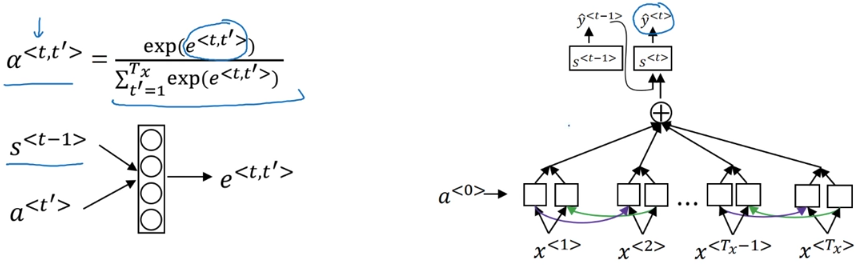

In [40]:
# https://www.cnblogs.com/hezhiyao/p/8747019.html Accuracy: 0.9966
cellSize1 = 32
cellSize2 = 52  #chosen to have similar number of trainable parameters as the two Bi-LSTM model
X = tf.keras.Input(shape=(Xlen, maxint))           #(bs,Xlen,maxint)
a = tf.keras.layers.Bidirectional(keras.layers.LSTM(cellSize1,
                                                    return_sequences = True))(X) #(bs,Xlen,2*cellSize1)

# define trainable layers here so that weights are shared over the output layer
dense1 = tf.keras.layers.Dense(10, activation = "tanh")
dense2 = tf.keras.layers.Dense(1, activation = "relu")
lstm = tf.keras.layers.LSTM(cellSize2, return_state = True)
dense = tf.keras.layers.Dense(maxint, activation='softmax')

outputs = []
for t in range(Ylen):
    if t==0:                                                     #hack to generate zeros of (bs,Xlen,cellSize2)
        prevh = tf.keras.layers.Lambda(lambda x:
                tf.tensordot(tf.zeros_like(x), tf.zeros([2*cellSize1,cellSize2]), [2,0]))(a)
    else:
        prevh = tf.keras.layers.RepeatVector(Xlen)(h)            #(bs,Xlen,cellSize2)
    concat = tf.keras.layers.concatenate([a,prevh], axis=-1)     #(bs,Xlen,2*cellSize1+cellSize2)
    e = dense1(concat)                                           #(bs,Xlen,10) 
    e = dense2(e)                                                #(bs,Xlen,1)  
    attn = tf.nn.softmax(e,axis=1)                               #(bs,Xlen,1)  #softmax applied on 2nd dim
    context = tf.keras.layers.dot([attn,a],axes=1)               #(bs,1,2*cellSize1) = sum_t' alpha_tt'*a_t'
    _, h, c = lstm(context, initial_state=[h,c] if t else None)  #(bs,cellSize2)*3
         
    out = dense(h)                                               #(bs,maxint)
    outputs.append(out)                                          #eventually (Ylen,bs,maxint)

outputs = tf.stack(outputs, axis=1)                              #(bs,Ylen,maxint)
model = tf.keras.Model(inputs=X, outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.count_params()

46634

## Train and Evaluate

In [19]:
# Train
import tempfile
_,weightsfile=tempfile.mkstemp()
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
es=EarlyStopping(monitor='val_loss', patience=1, verbose=1)
mc=ModelCheckpoint(weightsfile,monitor='val_loss',save_best_only=True,save_weights_only=True,verbose=0)

model.fit_generator(gen_pairs(32), steps_per_epoch=2000, epochs=500,callbacks=[es,mc],
                    validation_data=gen_pairs(128),validation_steps=500)
model.load_weights(weightsfile)

Epoch 1/500
2000/2000 [==============================] - 61s 30ms/step - loss: 0.9813 - acc: 0.6369 - val_loss: 0.5187 - val_acc: 0.8194
Epoch 2/500
2000/2000 [==============================] - 55s 27ms/step - loss: 0.3553 - acc: 0.8877 - val_loss: 0.2340 - val_acc: 0.9349
Epoch 3/500
2000/2000 [==============================] - 53s 27ms/step - loss: 0.1595 - acc: 0.9608 - val_loss: 0.1069 - val_acc: 0.9768
Epoch 4/500
2000/2000 [==============================] - 53s 27ms/step - loss: 0.0814 - acc: 0.9828 - val_loss: 0.0463 - val_acc: 0.9946
Epoch 5/500
2000/2000 [==============================] - 53s 27ms/step - loss: 0.0496 - acc: 0.9917 - val_loss: 0.0278 - val_acc: 0.9967
Epoch 6/500
2000/2000 [==============================] - 55s 27ms/step - loss: 0.0361 - acc: 0.9931 - val_loss: 0.0170 - val_acc: 0.9985
Epoch 7/500
2000/2000 [==============================] - 55s 28ms/step - loss: 0.0258 - acc: 0.9957 - val_loss: 0.0119 - val_acc: 0.9990
Epoch 8/500
2000/2000 [==================

In [38]:
# Evaluate
X,Y = next(gen_pairs(100))
Ypred = model.predict(X, verbose=0)
wrong = list(map(np.any, one_hot_decode(Y)-one_hot_decode(Ypred))) #np.any returns true (1) if any element is nonzero
print(f'Accuracy: {1-sum(wrong)/Y.shape[0]}') # different from acc during training as we count the WHOLE sequence as right/wrong here

for i in np.where(wrong)[0][:10]:    # output examples that are wrong
    print(f'True: {decode(Y[i])}, Prediction: {decode(Ypred[i])}')

Accuracy: 0.0
True: 2064-11-10, Prediction: nnnnnvvvvv
True: 2031-03-08, Prediction: vvvvvvvvvv
True: 2060-07-13, Prediction: vvvvvvvvvv
True: 2038-06-07, Prediction: vvvvvvvvvv
True: 1972-06-18, Prediction: vvvvvvvvvv
True: 2053-11-21, Prediction: vvvvvvvvvv
True: 2048-04-02, Prediction: vvvvvvvvvv
True: 2049-11-17, Prediction: vvvvvvvvvv
True: 2064-04-08, Prediction: vvvvvvvvvv
True: 2029-01-12, Prediction: vvvvvvvvvv


# Language translation

* https://www.tensorflow.org/alpha/tutorials/text/nmt_with_attention
* https://github.com/tensorflow/addons/tree/master/tensorflow_addons/seq2seq

## Data

In [41]:
import urllib, os, tempfile, zipfile
os.chdir(tempfile.gettempdir())
urllib.request.urlretrieve('http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip','spa-eng.zip')
zipfile.ZipFile('spa-eng.zip').extractall()
# ./spa-eng/spa.txt

In [42]:
import unicodedata, re

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # "he is a boy." => "he is a boy ." (https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation)
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.rstrip().strip()
    w = '<start> ' + w + ' <end>'
    return w

print(preprocess_sentence("May I borrow this book?"))
print(preprocess_sentence("¿Puedo tomar prestado este libro?").encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [43]:
import io
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    return zip(*word_pairs)

en, sp = create_dataset('spa-eng/spa.txt', None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [44]:
def max_length(tensor): return max(len(t) for t in tensor)
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer( filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
    return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):  # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset('spa-eng/spa.txt', num_examples)
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

from sklearn.model_selection import train_test_split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(24000, 24000, 6000, 6000)

In [45]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
7081 ----> suspendi
39 ----> las
2489 ----> pruebas
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
522 ----> failed
13 ----> the
2269 ----> tests
3 ----> .
2 ----> <end>


In [82]:
# Create a tf.data dataset
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)


example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

In [48]:
Xlen = example_input_batch.shape[1]
Ylen = example_target_batch.shape[1]

## One GRU + Bahdanau + One GRU

After embedding and GRU, get activations $\{a_t\}$ and hidden state (at final time) $h_T$.
$$\begin{aligned}
\text{attentions,  } \alpha_{tt'} &= {\rm softmax}_{\rm units}\left[{\rm Dense}\left(\{a_t\},h_T\right)\right] \\
\text{context,  }c_t &= \sum_{t'}\alpha_{tt'} a_{t'} \\
\end{aligned}$$
Decoder's activations $\tilde{a_t}$ and hidden states are $\tilde{h}_t$ are then computed by:
$$\begin{aligned}
\tilde{a_t}, \tilde{h}_t &= {\rm GRU}\left[{\rm concat}[{\rm embed}(o_{t-1}),c_t],\tilde{h}_{t-1}\right] \\
\text{outputs, } o_t&= {\rm softmax}\left[{\rm Dense}(\tilde{a}_t)\right] \\
\end{aligned}$$
To initialize the decoder,
$$\begin{aligned}
o_0&= \text{<start> tag} \\
\tilde{h}_0&= h_T \\
\end{aligned}$$
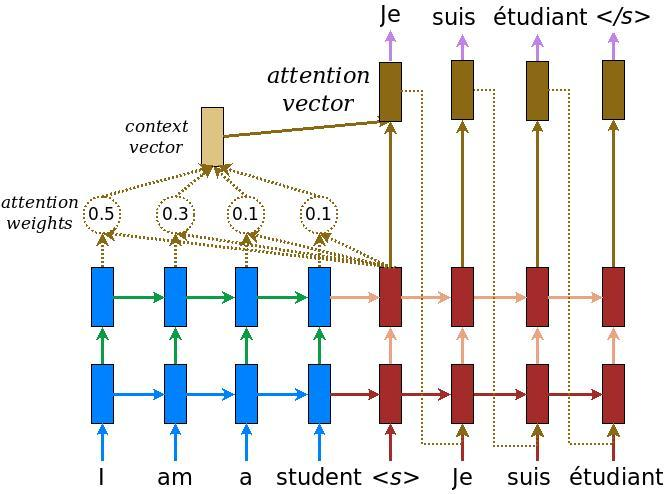

In [103]:
enc_units=dec_units=1024  #must be equal as hidden units from enc are fed to dec
embed_dim=256
##########################################################################################
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, units):
        super(Encoder, self).__init__()
        self.units = units #used when init hidden
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
    def call(self, x, hidden=None):
        x = self.embedding(x)       # (bs,Xlen,embed_dim)
        if hidden is None:
            hidden = tf.zeros((x.shape[0], enc_units))
        output, hidden = self.gru(x, initial_state = hidden) # (bs,Xlen,enc_units),(bs,enc_units)
        return output, hidden
    
encoder = Encoder(vocab_inp_size, embed_dim, enc_units)
sample_output, sample_hidden = encoder(example_input_batch)
##########################################################################################
class BahdanauAttention(tf.keras.Model):  #embedded in Decoder, not called directly
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, hidden, activation):               # (bs, enc_units), (bs,Xlen,enc_units)
        hidden = tf.expand_dims(hidden, 1)            # (bs, 1, enc_units)

        score = self.W1(activation) + self.W2(hidden) # (bs,Xlen,units)+(bs,1,units)=(bs,Xlen,units)
        score = self.V(tf.nn.tanh(score))             # (bs,Xlen,1)

        attn = tf.nn.softmax(score, axis=1)           # (bs,Xlen,1), softmax on 2nd dim
       
        context = attn * activation                   # (bs,Xlen,1)*(bs,Xlen,enc_units)=(bs,Xlen,enc_units)
        context = tf.reduce_sum(context, axis=1)      # (bs,enc_units)

        return context                               # (bs,enc_units)

attention_layer = BahdanauAttention(10)
context = attention_layer(sample_hidden, sample_output)
##########################################################################################
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, units):
        super(Decoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(units)

    def call(self, x, hidden, a): #x = prev output     # (bs, 1), (bs, enc_units), (bs,Xlen,enc_units)
        context = self.attention(hidden, a)      # (bs,enc_units), (bs,Xlen,1)

        x = self.embedding(x)                          # (bs, 1, embed_dim)

        x = tf.concat([tf.expand_dims(context, 1), x], axis=-1) # (bs, 1, embed_dim + enc_units)

        output, state = self.gru(x)                    # (bs, 1, dec_units), (bs, 1, dec_units)

        output = tf.reshape(output, (-1, output.shape[2])) # (bs, dec_units)
        x = self.fc(output)                                # (bs, vocab_size)

        return x, state       # (bs, vocab_size), (bs, 1, dec_units)

decoder = Decoder(vocab_tar_size, embed_dim, dec_units)
sample_decoder_output, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

In [104]:
encoder = Encoder(vocab_inp_size, embed_dim, enc_units)
decoder = Decoder(vocab_tar_size, embed_dim, dec_units)
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):  # do not compute loss on padded positions
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [ ]:
encoder.trainable_variables + decoder.trainable_variables

## Train

In [110]:
@tf.function
def train_step(inp, targ):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, hidden = encoder(inp)
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * inp.shape[0], 1)

        for t in range(1, targ.shape[1]):
            pred, hidden = decoder(dec_input, hidden, enc_output)  # enc_output to decoder
            loss += loss_function(targ[:, t], pred)
            dec_input = tf.expand_dims(targ[:, t], 1)                 # TRUE (not predicted) target as the next input

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        loss = train_step(inp, targ)

        if batch % 100 == 0:
            print(f'Epoch {epoch} Batch {batch} Loss {loss.numpy():.4f}')

## Evaluate

*    Don't use true target as decoder input. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
*    Stop predicting when the model predicts the end token.
*    Store the attention weights for every time step.

In [112]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''

    enc_out, hidden = encoder(inputs)

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                             hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0) # for next time step dec input

    return result, sentence, attention_plot

def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold ! <end> 


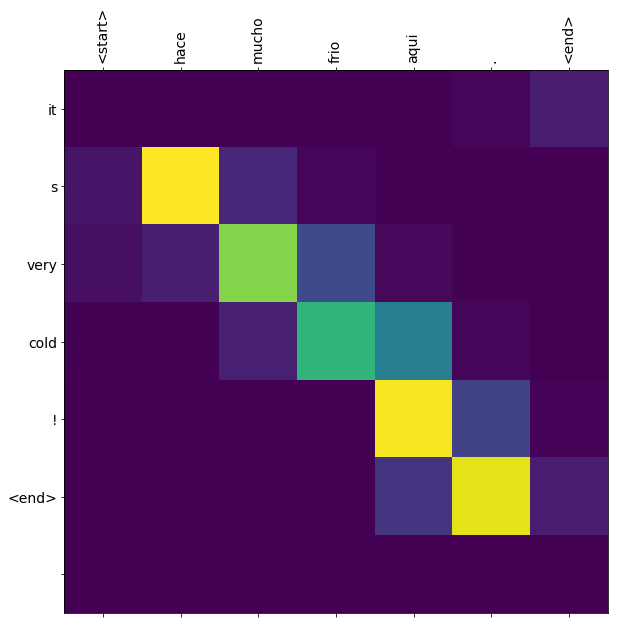

In [113]:
translate(u'hace mucho frio aqui.')

Input: <start> trata de averiguarlo . <end>
Predicted translation: let s figure it . <end> 


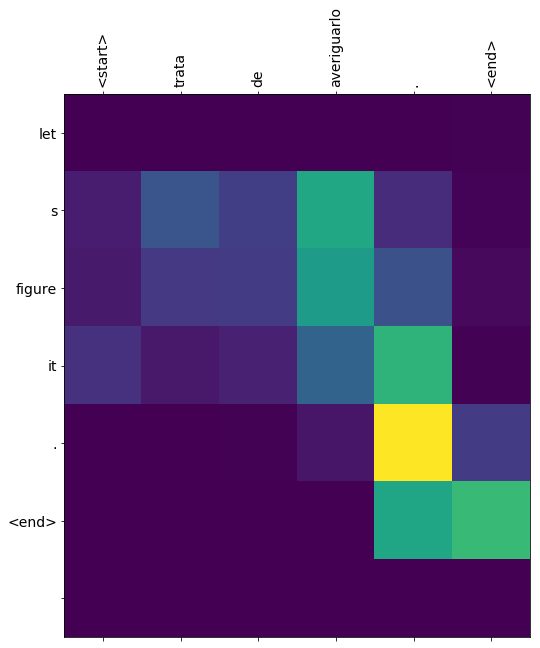

In [114]:
translate(u'trata de averiguarlo.')